In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import os, sys
import numpy as np
import json

import time
from datetime import timedelta
from collections import defaultdict
import argparse
import multiprocessing
import PIL.Image as Image
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

from panopticapi.panopticapi.utils import IdGenerator, rgb2id
OFFSET = 256 * 256 * 256
VOID = 0

# Visualization

In [18]:
generate_new_colors = True

json_file = '/media/storage/datasets/segmentation/annotations/panoptic_val2017.json'
segmentations_folder = '/media/storage/datasets/segmentation/annotations/panoptic_val2017/'
img_folder = '/media/storage/datasets/image/val2014/'
panoptic_coco_categories = 'panopticapi/panoptic_coco_categories.json'

In [19]:
with open(json_file, 'r') as f:
    coco_d = json.load(f)

ann = np.random.choice(coco_d['annotations'])

with open(panoptic_coco_categories, 'r') as f:
    categories_list = json.load(f)
categegories = {category['id']: category for category in categories_list}


In [20]:
img = None
for image_info in coco_d['images']:
    if image_info['id'] == ann['image_id']:
        try:
            img_name = f"COCO_val2014_{image_info['file_name']}"
            img = np.array(
                Image.open(os.path.join(img_folder, img_name))
            )
        except:
            print("Undable to find correspoding input image.")
        break

segmentation = np.array(
    Image.open(os.path.join(segmentations_folder, ann['file_name'])),
    dtype=np.uint8
)
segmentation_id = rgb2id(segmentation)
# find segments boundaries
boundaries = find_boundaries(segmentation_id, mode='thick')

In [21]:

if generate_new_colors:
    segmentation[:, :, :] = 0
    color_generator = IdGenerator(categegories)
    for segment_info in ann['segments_info']:
        color = color_generator.get_color(segment_info['category_id'])
        mask = segmentation_id == segment_info['id']
        segmentation[mask] = color

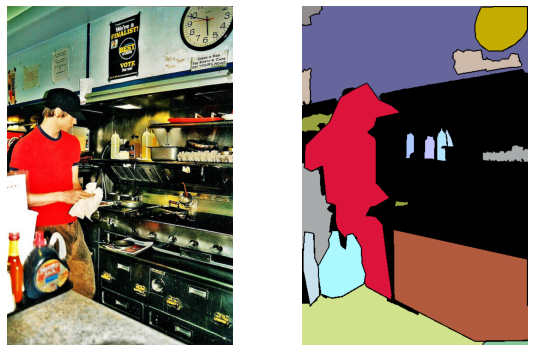

In [22]:
segmentation[boundaries] = [0, 0, 0]

if img is None:
    plt.figure()
    plt.imshow(segmentation)
    plt.axis('off')
else:
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(segmentation)
    plt.axis('off')
    plt.tight_layout()
plt.show()

# Evaluation

In [2]:
class PQStatCat():
    def __init__(self):
        self.iou = 0.0
        self.tp = 0
        self.fp = 0
        self.fn = 0

    def __iadd__(self, pq_stat_cat):
        self.iou += pq_stat_cat.iou
        self.tp += pq_stat_cat.tp
        self.fp += pq_stat_cat.fp
        self.fn += pq_stat_cat.fn
        return self

In [3]:
gt_json_file = "/media/storage/datasets/segmentation/annotations/panoptic_val2017.json"
gt_folder = "/media/storage/datasets/segmentation/annotations/panoptic_val2017"

In [23]:
with open(gt_json_file, 'r') as f:
    gt_json = json.load(f)
# with open(pred_json_file, 'r') as f:
#     pred_json = json.load(f)

if gt_folder is None:
    gt_folder = gt_json_file.replace('.json', '')
# if pred_folder is None:
#     pred_folder = pred_json_file.replace('.json', '')
categories = {el['id']: el for el in gt_json['categories']}

print("Evaluation panoptic segmentation metrics:")
print("Ground truth:")
print("\tSegmentation folder: {}".format(gt_folder))
print("\tJSON file: {}".format(gt_json_file))
# print("Prediction:")
# print("\tSegmentation folder: {}".format(pred_folder))
# print("\tJSON file: {}".format(pred_json_file))

Evaluation panoptic segmentation metrics:
Ground truth:
	Segmentation folder: /media/storage/datasets/segmentation/annotations/panoptic_val2017
	JSON file: /media/storage/datasets/segmentation/annotations/panoptic_val2017.json


In [5]:
# pred_annotations = {el['image_id']: el for el in pred_json['annotations']}
matched_annotations_list = []
for gt_ann in gt_json['annotations']:
    image_id = gt_ann['image_id']
    # if image_id not in pred_annotations:
    #     raise Exception('no prediction for the image with id: {}'.format(image_id))
    # matched_annotations_list.append((gt_ann, pred_annotations[image_id]))
    matched_annotations_list.append((gt_ann, image_id))

# pq_stat = pq_compute_multi_core(matched_annotations_list, gt_folder, pred_folder, categories)

metrics = [("All", None), ("Things", True), ("Stuff", False)]
results = {}

In [6]:
processes = []
processes.append(p)
pq_stat = PQStat()
for p in processes:
    pq_stat += p.get()
pq_stat

NameError: name 'p' is not defined

In [ ]:
pq_compute_single_core(proc_id, annotation_set, gt_folder, pred_folder, categories)

In [7]:
class PQStat():
    def __init__(self):
        self.pq_per_cat = defaultdict(PQStatCat)

    def __getitem__(self, i):
        return self.pq_per_cat[i]

    def __iadd__(self, pq_stat):
        for label, pq_stat_cat in pq_stat.pq_per_cat.items():
            self.pq_per_cat[label] += pq_stat_cat
        return self

    def pq_average(self, categories, isthing):
        pq, sq, rq, n = 0, 0, 0, 0
        per_class_results = {}
        for label, label_info in categories.items():
            if isthing is not None:
                cat_isthing = label_info['isthing'] == 1
                if isthing != cat_isthing:
                    continue
            iou = self.pq_per_cat[label].iou
            tp = self.pq_per_cat[label].tp
            fp = self.pq_per_cat[label].fp
            fn = self.pq_per_cat[label].fn
            if tp + fp + fn == 0:
                per_class_results[label] = {'pq': 0.0, 'sq': 0.0, 'rq': 0.0}
                continue
            n += 1
            pq_class = iou / (tp + 0.5 * fp + 0.5 * fn)
            sq_class = iou / tp if tp != 0 else 0
            rq_class = tp / (tp + 0.5 * fp + 0.5 * fn)
            per_class_results[label] = {'pq': pq_class, 'sq': sq_class, 'rq': rq_class}
            pq += pq_class
            sq += sq_class
            rq += rq_class

        return {'pq': pq / n, 'sq': sq / n, 'rq': rq / n, 'n': n}, per_class_results

In [9]:
pq_stat = PQStat()
# Ground truth
matched_annotations_list[0][0]
gt_ann = matched_annotations_list[0][0]

In [24]:
gt_ann

{'segments_info': [{'id': 3226956,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [413, 158, 53, 138],
   'area': 2840},
  {'id': 6979964,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [384, 172, 16, 36],
   'area': 439},
  {'id': 3103374,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [413, 223, 30, 81],
   'area': 1250},
  {'id': 2831194,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [291, 218, 62, 98],
   'area': 1848},
  {'id': 3496593,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [412, 219, 10, 13],
   'area': 90},
  {'id': 2633066,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [317, 219, 22, 12],
   'area': 212},
  {'id': 3165572,
   'category_id': 62,
   'iscrowd': 0,
   'bbox': [359, 218, 56, 103],
   'area': 2251},
  {'id': 8824489,
   'category_id': 64,
   'iscrowd': 0,
   'bbox': [237, 149, 24, 62],
   'area': 369},
  {'id': 3032951,
   'category_id': 67,
   'iscrowd': 0,
   'bbox': [321, 231, 126, 89],
   'area': 2134},
  {'id': 2038814,
   'category_id

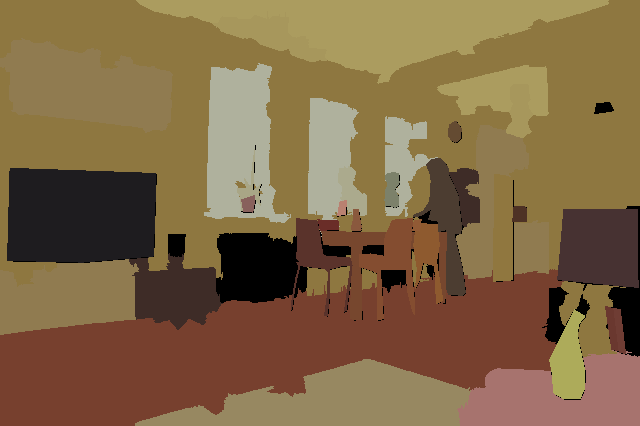

In [28]:
Image.open(os.path.join(gt_folder, gt_ann['file_name']))

In [41]:
gt_ann['file_name']

'000000000139.png'

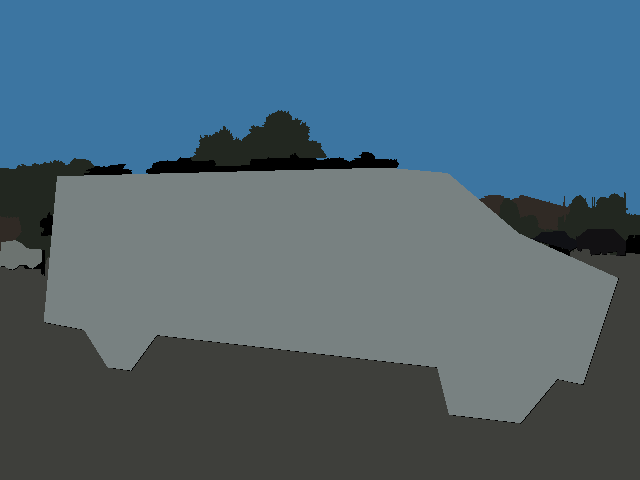

In [48]:
Image.open(os.path.join(gt_folder, "000000196759.png"))

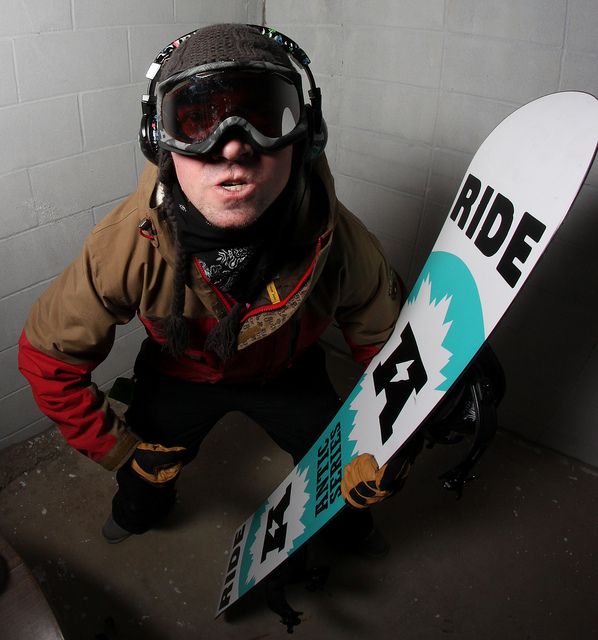

In [45]:
Image.open(os.path.join("/media/storage/datasets/image/val2014/", "COCO_val2014_000000000139.jpg"))

In [29]:
pan_gt = np.array(Image.open(os.path.join(gt_folder, gt_ann['file_name'])), dtype=np.uint32)
pan_gt = rgb2id(pan_gt)
# pan_pred = np.array(Image.open(os.path.join(pred_folder, pred_ann['file_name'])), dtype=np.uint32)
# pan_pred = rgb2id(pan_pred)
gt_segms = {el['id']: el for el in gt_ann['segments_info']}
# pred_segms = {el['id']: el for el in pred_ann['segments_info']}

In [30]:
gt_segms

{3226956: {'id': 3226956,
  'category_id': 1,
  'iscrowd': 0,
  'bbox': [413, 158, 53, 138],
  'area': 2840},
 6979964: {'id': 6979964,
  'category_id': 1,
  'iscrowd': 0,
  'bbox': [384, 172, 16, 36],
  'area': 439},
 3103374: {'id': 3103374,
  'category_id': 62,
  'iscrowd': 0,
  'bbox': [413, 223, 30, 81],
  'area': 1250},
 2831194: {'id': 2831194,
  'category_id': 62,
  'iscrowd': 0,
  'bbox': [291, 218, 62, 98],
  'area': 1848},
 3496593: {'id': 3496593,
  'category_id': 62,
  'iscrowd': 0,
  'bbox': [412, 219, 10, 13],
  'area': 90},
 2633066: {'id': 2633066,
  'category_id': 62,
  'iscrowd': 0,
  'bbox': [317, 219, 22, 12],
  'area': 212},
 3165572: {'id': 3165572,
  'category_id': 62,
  'iscrowd': 0,
  'bbox': [359, 218, 56, 103],
  'area': 2251},
 8824489: {'id': 8824489,
  'category_id': 64,
  'iscrowd': 0,
  'bbox': [237, 149, 24, 62],
  'area': 369},
 3032951: {'id': 3032951,
  'category_id': 67,
  'iscrowd': 0,
  'bbox': [321, 231, 126, 89],
  'area': 2134},
 2038814: {'id

In [ ]:
# pred_labels_set = set(el['id'] for el in pred_ann['segments_info'])
# labels, labels_cnt = np.unique(pan_pred, return_counts=True)

In [31]:
pan_gt_pred = pan_gt.astype(np.uint64) * OFFSET
# pan_gt_pred += pan_pred.astype(np.uint64)

In [32]:
pan_gt_pred

array([[ 70882227650560,  70882227650560,  70882227650560, ...,
         70882227650560,  70882227650560,  70882227650560],
       [ 70882227650560,  70882227650560,  70882227650560, ...,
         70882227650560,  70882227650560,  70882227650560],
       [ 70882227650560,  70882227650560,  70882227650560, ...,
         70882227650560,  70882227650560,  70882227650560],
       ...,
       [ 50854409273344,  50854409273344,  50854409273344, ...,
        121443002089472, 121443002089472, 121443002089472],
       [ 50854409273344,  50854409273344,  50854409273344, ...,
        121443002089472, 121443002089472, 121443002089472],
       [ 50854409273344,  50854409273344,  50854409273344, ...,
        121443002089472, 121443002089472, 121443002089472]], dtype=uint64)

In [35]:
gt_pred_map = {}
labels, labels_cnt = np.unique(pan_gt_pred, return_counts=True)

In [36]:
for label, intersection in zip(labels, labels_cnt):
    gt_id = label // OFFSET# gt color
    pred_id = label % OFFSET#prediction segmentation color
    gt_pred_map[(gt_id, pred_id)] = intersection

In [37]:
gt_pred_map

{(0.0, 0.0): 10194,
 (2038814.0, 0.0): 13247,
 (2437710.0, 0.0): 224,
 (2567230.0, 0.0): 5699,
 (2633066.0, 0.0): 212,
 (2831194.0, 0.0): 1848,
 (3031159.0, 0.0): 49754,
 (3032951.0, 0.0): 2134,
 (3094634.0, 0.0): 331,
 (3103374.0, 0.0): 1250,
 (3165572.0, 0.0): 2251,
 (3226956.0, 0.0): 2840,
 (3289671.0, 0.0): 5846,
 (3296100.0, 0.0): 227,
 (3423599.0, 0.0): 324,
 (3496593.0, 0.0): 90,
 (4086154.0, 0.0): 178,
 (4159376.0, 0.0): 2056,
 (4224910.0, 0.0): 83201,
 (5274512.0, 0.0): 25483,
 (5942189.0, 0.0): 2171,
 (6054280.0, 0.0): 187,
 (6068135.0, 0.0): 3391,
 (6266027.0, 0.0): 20106,
 (6391959.0, 0.0): 12618,
 (6979964.0, 0.0): 439,
 (7238567.0, 0.0): 9421,
 (7438777.0, 0.0): 120,
 (8824489.0, 0.0): 369,
 (9284267.0, 0.0): 842,
 (10334639.0, 0.0): 15587}

In [ ]:
# count all matched pairs
gt_matched = set()
pred_matched = set()
for label_tuple, intersection in gt_pred_map.items():
    gt_label, pred_label = label_tuple
    if gt_label not in gt_segms:
        continue
    # if pred_label not in pred_segms:
    #     continue
    if gt_segms[gt_label]['iscrowd'] == 1:
        continue
    # if gt_segms[gt_label]['category_id'] != pred_segms[pred_label]['category_id']:
    #     continue

    union = pred_segms[pred_label]['area'] + gt_segms[gt_label]['area'] - intersection - gt_pred_map.get((VOID, pred_label), 0)
    iou = intersection / union
    if iou > 0.5:
        pq_stat[gt_segms[gt_label]['category_id']].tp += 1
        pq_stat[gt_segms[gt_label]['category_id']].iou += iou
        gt_matched.add(gt_label)
        pred_matched.add(pred_label)

In [80]:
gt_segms[3094634]["area"] - intersection - gt_pred_map.get((VOID, pred_label), 0)

331